In [63]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [64]:
experiment_name = 'perceptual_chunks'

## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [65]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['perceptual_chunks']

# which iteration name should we use?
iteration_name = 'pilot_0c'
iteration_names = ['pilot_0','pilot_0b','pilot_0c']

# variables to check integrity of data
numTrials = 8

In [67]:
query = coll.find({"$and":[
                        {'trialType':'normal-trial'},
                        {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
                        {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                     })
pd.DataFrame(query)

""


## Data Cleaning

In [68]:
# Find people who have completed all trials
query = coll.find({"$and":[
                        {'trialType':'normal-trial'},
                        {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
                        {'trialNum': numTrials-1}]
                     })

complete_data_df = pd.DataFrame(query.sort('absoluteTime'))
complete_data_ids = list(complete_data_df['gameID'])
print(str(len(complete_data_ids)) + ' participants found')

50 participants found


## Trial Types

In [69]:
# Filter for full datasets
query = coll.find({"$and":[
                         {'trialType':'normal-trial'},
                         {'eventType':'trialEnd'},
                         {'iterationName': { '$in': iteration_names }},
                         {'gameID': { '$in': complete_data_ids } }
                        ]
                     })

df_trial = pd.DataFrame(list(query.sort('absoluteTime')))

df_trial = df_trial[['trialType', 'trialNum', 'targetName', 'bitmap', 'stimGrid', 'nReset', 'timeReset',
       'trialStartTime', 'lastActionTime', 'iterationName', 'devMode',
       'absoluteTime', 'eventType', 'gameID', 'gameGrid', 'gameStartTime',
       'relativeGameDuration', 'relativeTrialDuration', 'nChunksHighlighted',
       'highlightColors']]

df_trial['structureGrid'] = df_trial['gameGrid'].apply(lambda grid: np.array(grid)[5:13,0:8])

df_trial = df_trial.sort_values(by=['gameID', 'absoluteTime'])

In [70]:
query = coll.find({"$and":[
                         {'trialType':'normal-trial'},
                         {'eventType':'colorChange'},
                         {'iterationName': { '$in': ['pilot_0','pilot_0b'] }},
                         {'gameID': { '$in': complete_data_ids } }
                        ]
                     })

df_color = pd.DataFrame(list(query.sort('absoluteTime')))

In [71]:
# Filter for full datasets
query = coll.find({"$and":[
                         {'trialType':'normal-trial'},
                         {'eventType':'colorChange'},
                         {'iterationName': { '$in': ['pilot_0','pilot_0b'] }},
                         {'gameID': { '$in': complete_data_ids } }
                        ]
                     })

df_color = pd.DataFrame(list(query.sort('absoluteTime')))

df_color = df_color[['trialType', 'trialNum', 'targetName', 'bitmap', 'stimGrid', 'nReset', 'timeReset',
       'trialStartTime', 'lastActionTime', 'iterationName', 'devMode',
       'absoluteTime', 'eventType', 'gameID', 'gameGrid', 'gameStartTime',
       'relativeGameDuration', 'relativeTrialDuration', 'nChunksHighlighted',
       'highlightColors', 'colorType', 'dragSource', 'squaresSelected',
       'nSquaresSelected', 'nSquaresChanged', 'totalChunkSize',
       'newColorGroup', 'thinkingTime','releaseToReleaseInterval',
       'releaseToPressInterval', 'mouseDownTime', 'actionDuration', 'nAction']]

df_color['structureGrid'] = df_color['gameGrid'].apply(lambda grid: np.array(grid)[5:13,0:8])

df_color = df_color.rename(columns = {'thinkingTime':'releaseToReleaseInterval_from_thinkingTime'}) #renamed in experiment after first two ppts
# df_color = df_color.sort_values(by=['gameID', 'absoluteTime'])
# df_color

In [72]:
# look at survey responses
query = coll.find({"$and":[
                         {'trialType':'normal-trial'},
                         {'eventType':'survey'},
                         {'iterationName': { '$in': ['pilot_0','pilot_0b'] }},
                         {'gameID': { '$in': complete_data_ids } }
                        ]
                     })

df_survey = pd.DataFrame(list(query.sort('absoluteTime')))

df_survey = df_survey[['gameStartTime', 'comments', 'strategy', 
                       'didCorrectly', 'colorBlind','totalTimeAfterInstructions']]
df_survey.rename(columns = {'colorBlind':'notColorBlind'})

,gameStartTime,comments,strategy,didCorrectly,notColorBlind,totalTimeAfterInstructions
0,1.607546e+12,,,Yes,Yes,198679
1,1.607546e+12,No~~~,I colored the squares first and then the rest~~~,Yes,Yes,394523
2,1.607622e+12,No~~~,Colouring in the biggest areas I could with on...,Yes,Yes,259825
3,1.607622e+12,No,Splitting the shapes into four sided sections ...,Yes,Yes,299151
4,1.607623e+12,No problems,I tried to make the largest shapes possible an...,Yes,Yes,264475
5,1.607623e+12,no,I was colouring shapes based off what felt rig...,Yes,Yes,215023
6,1.607623e+12,No,Trying to be as symmetrical as possible,Yes,Yes,211615
7,1.607623e+12,n/a,I tried to identify square patterns within the...,Yes,Yes,232065
8,1.607623e+12,no,i just tried to find matching shapes,Yes,Yes,425715
9,1.607623e+12,No,Just saw shapes and filled them in,Yes,Yes,1176834


## Save data

In [73]:
# # save to csvs (not used- use pickle instead)

# trial_path = os.path.join(csv_dir,'perceptual_chunks_trial_{}.csv'.format(iteration_name))
# df_trial.to_csv(trial_path)
# color_path = os.path.join(csv_dir,'perceptual_chunks_color_{}.csv'.format(iteration_name))
# df_color.to_csv(color_path)
# survey_path = os.path.join(csv_dir,'perceptual_chunks_survey_{}.csv'.format(iteration_name))
# df_survey.to_csv(survey_path)

In [74]:
trial_path_p = os.path.join(csv_dir,'perceptual_chunks_trial_{}.p'.format(iteration_name))
pickle.dump(df_trial, open(trial_path_p, "wb" ))

In [75]:
color_path_p = os.path.join(csv_dir,'perceptual_chunks_color_{}.p'.format(iteration_name))
pickle.dump(df_color, open(color_path_p, "wb" ))

In [76]:
survey_path_p = os.path.join(csv_dir,'perceptual_chunks_survey_{}.p'.format(iteration_name))
pickle.dump(df_survey, open(survey_path_p, "wb" ))

## Inspect data

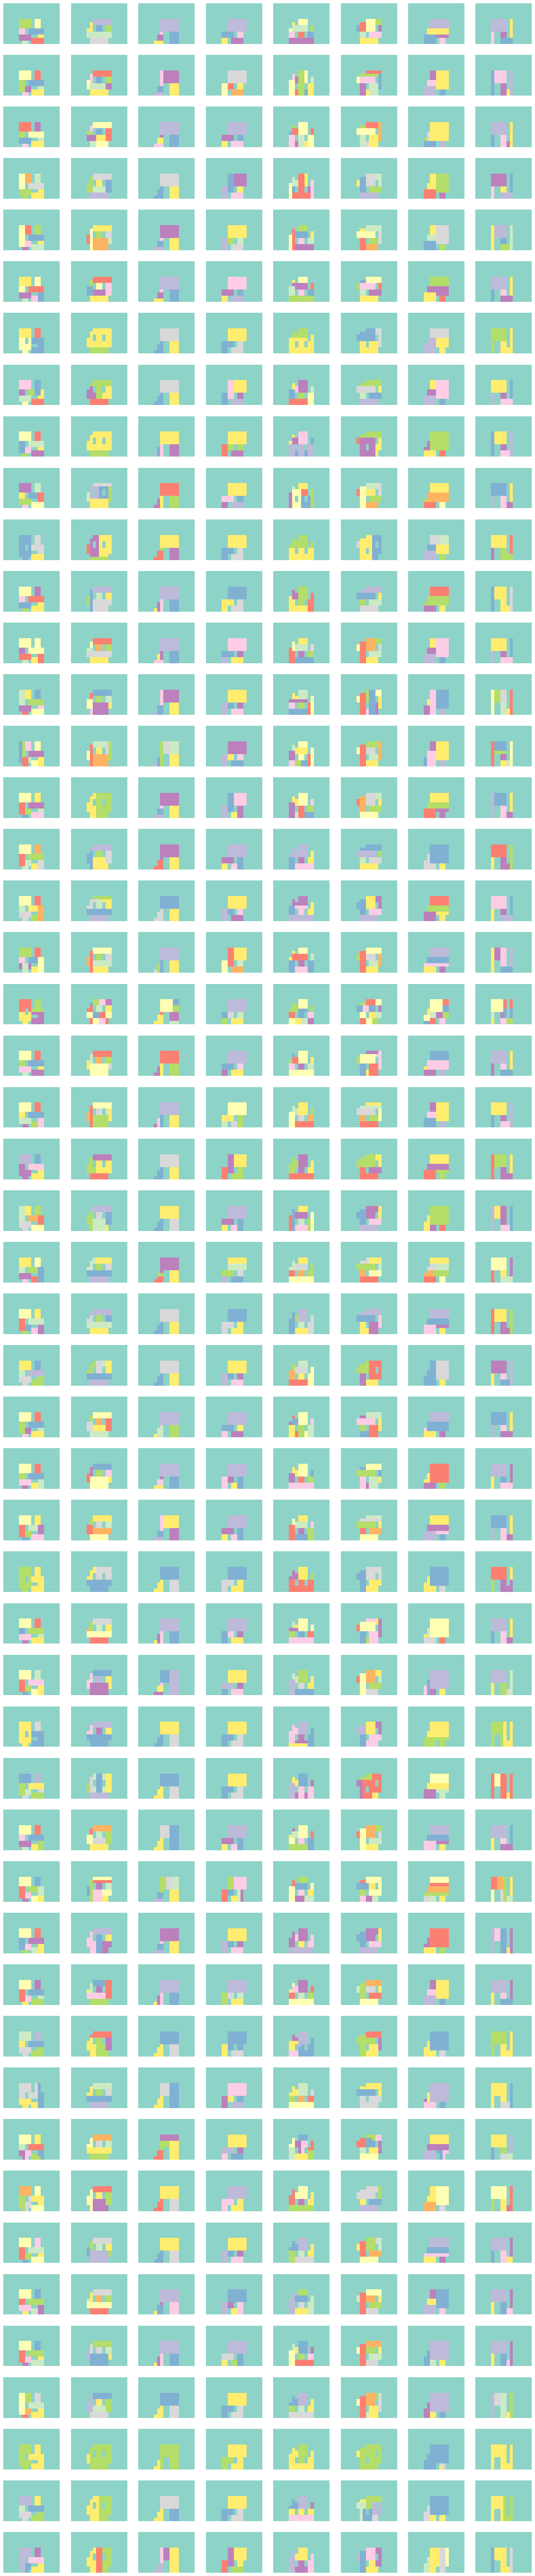

In [77]:
# visualize all participant's chunks

ppts = complete_data_ids
targets = df_trial.targetName.unique()
n_ppt = len(ppts)

fig, axs = plt.subplots(n_ppt, numTrials, figsize=(20,2*n_ppt))

for i, ppt in enumerate(ppts):

    for j, target in enumerate(targets):

        chunks = df_trial[(df_trial.gameID==ppt) & (df_trial.targetName==target)]['gameGrid'].iloc[0]
        chunks = np.rot90(chunks)
        axs[i,j].axis('off')
        axs[i,j].imshow(chunks, cmap='Set3')

In [ ]:
# visualize one participant's chunks

ppt_num = -1 #-1 for latest ppt
gameID = complete_data_ids[ppt_num]

# gameID = '' # or manually enter a gameID

df_test = df_trial[df_trial.gameID==gameID].reset_index()

for i in range(0,8):

    chunks = df_test.loc[i,'gameGrid']

    av_map = np.rot90(chunks)
    fig, ax = plt.subplots(figsize=(3,2))
    ax.axis('off')
    ax.imshow(av_map, cmap='Set3')

/bin/sh: tunnel_cogtoolslab: command not found
